In [1]:
# !pip install mplfinance -qqq

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import ta
from ta.volatility import AverageTrueRange
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
import requests
import json
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import xgboost
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Permute, Reshape, Multiply, Flatten, Input
from tensorflow.keras.layers import AdditiveAttention # Make sure this is correctly imported
from tensorflow.keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import mplfinance as mpf
import matplotlib.dates as mpl_dates


In [2]:
print(tf.__version__)

2.19.0


In [3]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(
    period="max",
    interval="1h", 
)
print(msft_df.head())
msft_df.shape

                                 Open        High         Low       Close  \
Datetime                                                                    
2023-06-27 09:30:00-04:00  331.859985  334.114410  331.119995  332.000000   
2023-06-27 10:30:00-04:00  331.989990  332.107300  329.299988  331.873413   
2023-06-27 11:30:00-04:00  331.920013  332.839996  331.269989  331.970001   
2023-06-27 12:30:00-04:00  331.970001  333.510010  331.700012  333.312897   
2023-06-27 13:30:00-04:00  333.320007  335.815002  333.320007  335.480011   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2023-06-27 09:30:00-04:00  4718321        0.0           0.0  
2023-06-27 10:30:00-04:00  2911379        0.0           0.0  
2023-06-27 11:30:00-04:00  1904459        0.0           0.0  
2023-06-27 12:30:00-04:00  2752173        0.0           0.0  
2023-06-27 13:30:00-04:00  2018662        0.0           0.0  


(3487, 7)

# Preprocessing

## Handling NaNs

In [4]:
msft_df.isnull().sum().sum()

0

## Handling Outliers

In [5]:
Q1 = msft_df.quantile(0.25)
Q3 = msft_df.quantile(0.75)
IQR = Q3 - Q1

df_no_outliers = msft_df[~((msft_df < (Q1 - 3 * IQR)) | (msft_df > (Q3 + 3 * IQR))).any(axis=1)]
print(f"The Amount of Outliers Removed: {msft_df.shape[0] - df_no_outliers.shape[0]}")

The Amount of Outliers Removed: 93


## Handling Duplicates

In [6]:
msft_df.duplicated().sum()

0

## Feature Engineering

### Lagged Prices

In [7]:
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    lag_periods = [1, 2, 3, 4, 5, 6] # within 1 day range
    for lag in lag_periods:
        msft_df[f'{col}_price_lag_{lag}H'] = msft_df[col].shift(lag)

### Lagged Returns

#### Hourly

In [8]:
msft_df['Hourly_return'] = msft_df['Close'].pct_change(periods=1)
lag_returns_hourly = [1, 2, 3, 4, 5, 6] # range within 1 day
for lag in lag_returns_hourly:
    msft_df[f'Hourly_return_lag_{lag}H'] = msft_df['Hourly_return'].shift(lag)

#### Daily

In [9]:
msft_df['Daily_return'] = msft_df['Close'].pct_change(periods=7)
lag_returns_daily = [7,14,21,28] # 1-4 day range
for lag in lag_returns_daily:
    msft_df[f'Daily_return_lag_{lag}H'] = msft_df['Daily_return'].shift(lag)

#### Weekly

Generates too many NaN values.

In [10]:
msft_df['Weekly_return'] = msft_df['Close'].pct_change(periods=35)
lag_returns_weekly = [35] # range within 2 weeks
for lag in lag_returns_weekly:
    msft_df[f'weekly_return_lag_{lag}H'] = msft_df['Weekly_return'].shift(lag)

### Moving Averages

#### Simple

In [11]:
sma_windows = [5, 7, 10, 21, 28, 35]
for window in sma_windows:
    msft_df[f'SMA_{window}H'] = msft_df['Close'].rolling(window=window).mean()

#### Exponential

In [12]:
ema_windows = [5, 7, 10, 21, 28, 35]
for window in ema_windows:
    msft_df[f'EMA_{window}H'] = msft_df['Close'].ewm(span=window, adjust=False).mean()

### Logarithmic Simple 

In [13]:
msft_df['Log_Close'] = np.log(msft_df['Close'])
msft_df['Rolling_Log_Avg'] = msft_df['Log_Close'].rolling(7).mean()
msft_df['Rolling_Log_Std'] = msft_df['Log_Close'].rolling(7).std()

### Volatility

#### Standard Deviation

Use returns rather than raw price for STD due to returns having stationarity.

In [14]:
volatility_window = [3, 7, 14, 21, 28, 35]

for window in volatility_window:
    msft_df[f'Volatility_StdDEV_{window}H'] = msft_df['Hourly_return'].rolling(window=window).std()

### Technical Indicators

#### Average True Range (Volatility)

In [15]:
atr_periods = [7, 14, 21, 28, 35]

for period in atr_periods:
    atr = AverageTrueRange(
        high=msft_df['High'],
        low=msft_df['Low'],
        close=msft_df['Close'].shift(1),
        window=period,
        fillna=False
    )
    msft_df[f'ATR_{period}H'] = atr.average_true_range()

#### RSI (Momentum Indicator)

In [16]:
from ta.momentum import RSIIndicator

rsi_indicator = RSIIndicator(close=msft_df['Close'], window=14)


msft_df['RSI_14'] = rsi_indicator.rsi()

msft_df['RSI_Overbought'] = (msft_df['RSI_14'] > 70).astype(int)
msft_df['RSI_Oversold'] = (msft_df['RSI_14'] < 30).astype(int)

#### MACD (Momentum Indicator)

In [ ]:
from ta.trend import MACD

macd_indicator = MACD(
    close=msft_df['Close'],
    window_slow=26,
    window_fast=12,
    window_sign=9,
    fillna=False
)

msft_df['MACD'] = macd_indicator.macd()
msft_df['MACD_Signal'] = macd_indicator.macd_signal()
msft_df['MACD_Histogram'] = macd_indicator.macd_diff()

msft_df['MACD_Prev'] = msft_df['MACD'].shift(1)
msft_df['MACD_Signal_Prev'] = msft_df['MACD_Signal'].shift(1)
msft_df['MACD_Cross_Up'] = ((msft_df['MACD'] > msft_df['MACD_Signal']) & (msft_df['MACD_Prev'] <= msft_df['MACD_Signal_Prev'])).astype(int)
msft_df['MACD_Cross_Down'] = ((msft_df['MACD'] < msft_df['MACD_Signal']) & (msft_df['MACD_Prev'] >= msft_df['MACD_Signal_Prev'])).astype(int)

#### Bollinger Bands (Volatility Indicator)

In [18]:
from ta.volatility import BollingerBands


bb_indicator = BollingerBands(
    close=msft_df['Close'],
    window=2,         
    window_dev=2,     
    fillna=False
)

msft_df['Bollinger_Lower'] = bb_indicator.bollinger_lband()
msft_df['Bollinger_Middle'] = bb_indicator.bollinger_mavg()
msft_df['Bollinger_Upper'] = bb_indicator.bollinger_hband()
msft_df['Bollinger_Bandwidth_Raw'] = bb_indicator.bollinger_wband()
msft_df['Bollinger_PercentageB'] = bb_indicator.bollinger_pband()

msft_df['Bollinger_Bandwidth'] = msft_df['Bollinger_Bandwidth_Raw'] / 100
msft_df['Price_Above_Upper_BB'] = (msft_df['Close'] > msft_df['Bollinger_Upper']).astype(int)
msft_df['Price_Below_Lower_BB'] = (msft_df['Close'] < msft_df['Bollinger_Lower']).astype(int)

#### Stochastic Oscillator (Momentum Indicator)

In [19]:
from ta.momentum import StochasticOscillator

# Create the Stochastic Oscillator object
stoch = StochasticOscillator(
    high=msft_df['High'],
    low=msft_df['Low'],
    close=msft_df['Close'],
    window=14,      
    smooth_window=3, 
    fillna=False
)

msft_df['%K'] = stoch.stoch()

msft_df['%D'] = stoch.stoch_signal()

#### ADX (Trend/Momentum Indicator)

In [20]:
from ta.trend import ADXIndicator


adx = ADXIndicator(
    high=msft_df['High'],
    low=msft_df['Low'],
    close=msft_df['Close'],
    window=14,
    fillna=False
)


msft_df['ADX_14'] = adx.adx()
msft_df['Positive_DI'] = adx.adx_pos()
msft_df['Negative_DI'] = adx.adx_neg()


msft_df['Trend_Strong_ADX'] = (msft_df['ADX_14'] > 25).astype(int)


### Time Stamps

In [21]:
msft_df['Hour'] = msft_df.index.hour
msft_df['Day_of_Week'] = msft_df.index.dayofweek
msft_df['Day_of_Month'] = msft_df.index.day
msft_df['Month'] = msft_df.index.month
msft_df['Year'] = msft_df.index.year
msft_df['Week_of_Year'] = msft_df.index.isocalendar().week.astype(int)

C:\Users\billy\AppData\Local\Temp\ipykernel_54204\2403176649.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour'] = msft_df.index.hour
C:\Users\billy\AppData\Local\Temp\ipykernel_54204\2403176649.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Day_of_Week'] = msft_df.index.dayofweek
C:\Users\billy\AppData\Local\Temp\ipykernel_54204\2403176649.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Converting hourly and weekly data to sin, cosine. One Hot Encoding categorical data.

In [ ]:
msft_df['Hour_sin'] = np.sin(2 * np.pi * msft_df['Hour'] / 24)
msft_df['Hour_cos'] = np.cos(2 * np.pi * msft_df['Hour'] / 24)
msft_df['Day_of_Week_sin'] = np.sin(2 * np.pi * msft_df['Day_of_Week'] / 7)
msft_df['Day_of_Week_cos'] = np.cos(2 * np.pi * msft_df['Day_of_Week'] / 7)
msft_df = pd.get_dummies(msft_df, columns=['Day_of_Week'], prefix='Day', drop_first=False)
msft_df = pd.get_dummies(msft_df, columns=['Month'], prefix='Month', drop_first=False)

C:\Users\billy\AppData\Local\Temp\ipykernel_54204\2951078873.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour_sin'] = np.sin(2 * np.pi * msft_df['Hour'] / 24)
C:\Users\billy\AppData\Local\Temp\ipykernel_54204\2951078873.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  msft_df['Hour_cos'] = np.cos(2 * np.pi * msft_df['Hour'] / 24)
C:\Users\billy\AppData\Local\Temp\ipykernel_54204\2951078873.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

### Volume Based

#### Moving Average

In [23]:
for window in [7, 14, 21, 28, 35]:
    msft_df[f'Volume_SMA_{window}H'] = msft_df['Volume'].rolling(window=window).mean()
msft_df['Volume_Change'] = msft_df['Volume'].pct_change()

#### On-Balanced Volume (Momentum Indicator)

In [24]:
from ta.volume import OnBalanceVolumeIndicator

# Create the OBV indicator object
obv_indicator = OnBalanceVolumeIndicator(
    close=msft_df['Close'],
    volume=msft_df['Volume'],
    fillna=False
)

# Calculate OBV and its 9-period EMA
msft_df['OBV'] = obv_indicator.on_balance_volume()
msft_df['OBV_EMA_9H'] = msft_df['OBV'].ewm(span=9, adjust=False).mean()

#### Price Action Patterns

In [25]:
msft_df['High_Low_Range'] = msft_df['High'] - msft_df['Low']
msft_df['Open_Close_Range'] = msft_df['Close'] - msft_df['Open']
msft_df['High_Low_Range_Pct'] = (msft_df['High'] - msft_df['Low']) / msft_df['Close'] * 100
msft_df['Open_Close_Range_Pct'] = (msft_df['Close'] -  msft_df['Open']) / msft_df['Open'] * 100

### Other

In [26]:
msft_df['RSI_x_Volume'] = msft_df['RSI_14'] * msft_df['Volume']

### Imputation

In [27]:
print("amount of nans before accounting for largest window size:", msft_df.isna().sum().sum())

amount of nans before accounting for largest window size: 878


In [28]:
msft_df = msft_df.iloc[35:]
print("amount of nans after accounting for largest window size:", msft_df.isna().sum().sum())

amount of nans after accounting for largest window size: 38


In [29]:
print(msft_df.dtypes[msft_df.isna().any()])

weekly_return_lag_35H    float64
Bollinger_PercentageB    float64
dtype: object


In [30]:
#msft_df[msft_df['Bollinger_PercentageB'].isna()]
print(f"Bollinger_PercentageB NaN count:", msft_df['Bollinger_PercentageB'].isna().sum().sum())
# We can fill these NaNs with imputation function.

Bollinger_PercentageB NaN count: 3


In [31]:
print(f"weekly_return_lag_35H NaN count:", msft_df['weekly_return_lag_35H'].isna().sum())
# we cannot fill these values with imputation function, since they are NaN's and their type if best filled with
# forward fill, but their beginning values are NaN's, so forward fill doesn't work.

weekly_return_lag_35H NaN count: 35


In [32]:
rows_to_drop = msft_df['weekly_return_lag_35H'].isna().sum()
total_columns = msft_df.shape[1]
datapoints_lost_rows = rows_to_drop * total_columns
print(f"Datapoints lost by dropping {rows_to_drop} rows: {datapoints_lost_rows:,}")

rows_total = msft_df.shape[0]
datapoints_lost_column = rows_total
print(f"Datapoints lost by dropping the column: {datapoints_lost_column:,}")
# Because of this point discrepancy we drop the column weekly_return_lag_35H

Datapoints lost by dropping 35 rows: 4,865
Datapoints lost by dropping the column: 3,452


In [33]:
msft_df.drop(columns=['weekly_return_lag_35H'], inplace=True)
print(f"Amount of NaNs after dropping the column:", msft_df.isna().sum().sum())

Amount of NaNs after dropping the column: 3


- Why ffill? These features are inherently backward-looking and computed from previous data. If a value is missing, the last valid one is usually the best proxy.
    - Advantage: Less noise than forward fill or mean imputation, and more robust to outliers than expanding mean.
- Why expanding median? Technical indicators are statistical constructs; using a growing median helps smooth extreme values while gradually building signal integrity over time.
- Why linear interpolation? Prices and returns change gradually and are often assumed to follow continuous trends. Linear interpolation estimates these points realistically without dragging forward stale data.
    -  Especially good for: Return features derived from price differences, where forward-filling would misrepresent rate of change

In [34]:
def impute_features(df):
    for col in df.columns:
        col_lower = col.lower()

        # columns that are not features
        if col_lower in ['Close']:
            continue

        # Rolling Averages, Price Lags, Return Lags, Volume-related, Log features
        if any(key in col_lower for key in ["price_lag", "hourly_return_lag", "daily_return_lag", 
                        "weekly_return_lag_", "sma", "ema", "volume", "rolling_log_avg", "rolling_log_std", "volatility"]):
            df[col] = df[col].ffill()

        # Technical Indicators
        elif any(key in col_lower for key in ["atr", "rsi", "macd", "bollinger", "upper_bb", "lower_bb", "adx", "di", "%d", "%k", "obv"]):
            df[col] = df[col].fillna(df[col].expanding().median())

        # Price Features
        elif any(key in col_lower for key in ["low_range", "close_range", "range_pct", "rsi_x_volume"]):
            df[col] = df[col].interpolate(method='linear')

        else:
            df[col] = df[col].interpolate(method='linear').ffill().bfill()

        
    return df

In [35]:
impute_features(msft_df)
print("amount of nans after accounting for imputing:", msft_df.isna().sum().sum())

amount of nans after accounting for imputing: 0


### Scaling

In [36]:
# # inf = msft_df.isin(['inf', '-inf'])
# # print("Total infinity values", inf.values.sum())
# # inf[inf.any(axis=1)]
# plt.figure(figsize=(16, 8))
# sns.heatmap(inf, cmap="autumn", cbar=False, yticklabels=False)
# plt.title("🔍 Heatmap of Infinity Values in msft_df")
# plt.xlabel("Features")
# plt.ylabel("Timestamps")
# plt.tight_layout()
# plt.show()

In [37]:
msft_df.replace([np.inf, -np.inf], np.nan, inplace=True)
impute_features(msft_df)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open_price_lag_1H,Open_price_lag_2H,Open_price_lag_3H,...,Volume_SMA_28H,Volume_SMA_35H,Volume_Change,OBV,OBV_EMA_9H,High_Low_Range,Open_Close_Range,High_Low_Range_Pct,Open_Close_Range_Pct,RSI_x_Volume
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-07-05 13:30:00-04:00,338.549988,338.799988,337.640015,338.029999,1375275,0.0,0.0,339.140015,338.730011,340.440002,...,2.322095e+06,2.371685e+06,0.191958,3335607,5.724248e+06,1.159973,-0.519989,0.343157,-0.153593,7.089970e+07
2023-07-05 14:30:00-04:00,338.059998,338.750000,338.000000,338.369995,1284704,0.0,0.0,338.549988,339.140015,338.730011,...,2.279116e+06,2.325209e+06,-0.065857,4620311,5.503460e+06,0.750000,0.309998,0.221651,0.091699,6.771939e+07
2023-07-05 15:30:00-04:00,338.399994,338.670013,337.799988,338.160004,1754385,0.0,0.0,338.059998,338.549988,339.140015,...,2.282647e+06,2.320921e+06,0.365595,2865926,4.975954e+06,0.870026,-0.239990,0.257282,-0.070919,9.102884e+07
2023-07-06 09:30:00-04:00,337.299988,340.649994,335.500000,340.609711,8464457,0.0,0.0,338.399994,338.059998,338.549988,...,2.504760e+06,2.484129e+06,3.824743,11330383,6.246839e+06,5.149994,3.309723,1.511993,0.981240,5.061498e+08
2023-07-06 10:30:00-04:00,340.579987,341.119995,338.089996,338.700012,3748565,0.0,0.0,337.299988,338.399994,338.059998,...,2.571333e+06,2.533555e+06,-0.557141,7581818,6.513835e+06,3.029999,-1.879974,0.894597,-0.551992,1.969658e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-25 11:30:00-04:00,492.570007,492.709991,491.149994,491.614990,1207466,0.0,0.0,493.619995,491.609985,490.820007,...,2.595252e+06,2.371831e+06,-0.267709,238538099,2.391876e+08,1.559998,-0.955017,0.317321,-0.193885,8.225291e+07
2025-06-25 12:30:00-04:00,491.630005,491.659912,490.109985,490.640015,1174224,0.0,0.0,492.570007,493.619995,491.609985,...,2.608010e+06,2.373816e+06,-0.027530,237363875,2.388228e+08,1.549927,-0.989990,0.315899,-0.201369,7.529843e+07
2025-06-25 13:30:00-04:00,490.609985,490.799988,489.390015,490.479797,1147401,0.0,0.0,491.630005,492.570007,493.619995,...,2.600699e+06,2.371716e+06,-0.022843,236216474,2.383016e+08,1.409973,-0.130188,0.287468,-0.026536,7.282273e+07


In [38]:
X = msft_df.drop(columns=['Close'])
y = msft_df['Close']

X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

## Sequence

In [39]:
# 35 hours of data for each sequence
# This means each sequence will contain 35 hours of features to predict the next hour's price

def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X), 1):
        current_X_sequence = X[i-window_size:i]
        current_y_value = y[i]

        Xs.append(current_X_sequence)
        ys.append(current_y_value)
    return np.array(Xs), np.array(ys)
    
        
# I am converting to 3d (for x only - y will be 2 dimensional) for my LSTM model. The shape will return the count of 
# 2d arrays in the list (# of sequences), rows of each 2d array (window size), 
# and columns of each 2d array (number of features)
# I've added a depth dimension. Think of a spreadsheet(2d table of rows and columns),
# and put these spreadsheets into a binder, the binder now has a depth dimension (number of spreadsheets).
    
window_size = 35
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size)

In [40]:
# the 35 lost values are the values in the first window - 
# because they don't have preceding values to create a sequence they're lost.
print(X_scaled.shape)
print(y_scaled.shape)
print(X_seq.shape)
print(y_seq.shape)

(3452, 137)
(3452, 1)
(3417, 35, 137)
(3417, 1)


## TimeSeriesSplit (Training Data)

In [ ]:
tscv = TimeSeriesSplit(n_splits=100)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

actual_values = []
predicted_values = []

for i, (train_idx, test_idx) in enumerate(tscv.split(X_seq)): 
    print("fold:", i)
    print("Train dates (approx):", msft_df.index[train_idx + window_size -1][[0, -1]]) 
    print("Test dates (approx):", msft_df.index[test_idx + window_size -1][[0, -1]])

    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2)) # optimizing the model
    model.add(BatchNormalization()) # optimizing the model
    model.add(Dense(units=1)) 
    model.compile(optimizer='adam', loss='mean_squared_error')
    lstm_fit= model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])
    y_pred = model.predict(X_test[:1])
    actual_values.append(y_test[0])
    predicted_values.append(y_pred[0][0])


In [51]:
X_test[:1]

array([[[0.89713594, 0.89321154, 0.89507616, ..., 0.03278912,
         0.26737393, 0.04100668],
        [0.89345335, 0.89441108, 0.89933868, ..., 0.01646425,
         0.29846153, 0.03231384],
        [0.89623573, 0.89217558, 0.88256194, ..., 0.09438685,
         0.21440079, 0.03461188],
        ...,
        [0.91265679, 0.91343989, 0.91742709, ..., 0.02140904,
         0.29703857, 0.05307589],
        [0.91478453, 0.91327632, 0.9017432 , ..., 0.10323932,
         0.29535011, 0.07123462],
        [0.91685766, 0.9178836 , 0.91731786, ..., 0.04539087,
         0.29701989, 0.03610069]]])

In [48]:
results_df = pd.DataFrame({
    "Actual_vs_Predicted": [model.evaluate(X_test, y_test)],
})
print(results_df)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0016
   Actual_vs_Predicted
0             0.001609


## Performance Eval

In [ ]:
mae = mean_absolute_error(y_test, predicted_values)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, predicted_values))

In [ ]:
mape = mean_absolute_percentage_error(y_test, predicted_values)

In [ ]:
r2 = r2_score(y_test, predicted_values)

In [ ]:
print("Mean Squared Error:", test_loss)
print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)
print("Mean Absolute Percentage Error:", mape)
print("R-squared:", r2)

Mean Squared Error: 0.0015568201197311282
Mean Absolute Error:  0.022865026347151627
Root Mean Square Error:  0.02787688690895426
Mean Absolute Percentage Error: 0.02464321330576453
R-squared: 0.20303920902721284


### Generating Predictions

In [ ]:
# last_week_df = msft_df[-29:] # I'm using the last week of data to predict the next hour

In [ ]:
# last_week_features = last_week_df.drop(columns=['Close'])
# last_week_features.shape

(29, 137)

In [ ]:
# last_week_X_scaled = X_scaler.transform(last_week_features)

In [ ]:
# last_week_X_scaled = last_X_scaled.reshape(1, 29, -1)

In [ ]:
# y_pred = model.predict(last_week_X_scaled)
# last_y_pred = y_pred[:, -1, :]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


In [ ]:
# predicted_close = y_scaler.inverse_transform(last_y_pred)[0][0]
# predicted_close

491.9395

<!-- ### Visualizing Predictions -->

In [ ]:
# most_recent_date = last_week_df.index[-1]
# most_recent_date

Timestamp('2025-06-25 12:30:00-0400', tz='America/New_York')

In [ ]:
# next_hour = most_recent_date + pd.Timedelta(hours=1)
# next_hour

Timestamp('2025-06-25 13:30:00-0400', tz='America/New_York')

In [ ]:
# prediction_dates = pd.date_range(start=next_hour, periods=1, freq='h')
# prediction_dates

DatetimeIndex(['2025-06-25 13:30:00-04:00'], dtype='datetime64[ns, America/New_York]', freq='h')

In [ ]:
# prediction_df = pd.DataFrame(index=prediction_dates, data=predicted_close, columns=['Close'])
# predicted_close

,Close
2025-06-25 13:30:00-04:00,491.939514


In [ ]:
# last_real = last_week_df.iloc[-1]
# last_real

Open                         491.630005
High                         491.659912
Low                          490.109985
Close                        490.329987
Volume                           753982
                             ...       
High_Low_Range                 1.549927
Open_Close_Range              -1.300018
High_Low_Range_Pct             0.316099
Open_Close_Range_Pct           -0.26443
RSI_x_Volume            47464966.868817
Name: 2025-06-25 12:30:00-04:00, Length: 138, dtype: object

In [ ]:
# last_real = last_week_df.iloc[-1]

# # Simulate the predicted candlestick
# next_hour = last_week_df.index[-1] + pd.Timedelta(hours=1)
# predicted_candle = pd.DataFrame({
#     'Open': [last_real['Close']],
#     'High': [max(last_real['Close'], predicted_close) + 0.5],
#     'Low': [min(last_real['Close'], predicted_close) - 0.5],
#     'Close': [predicted_close],
#     'Volume': [0]  # you can leave it 0 if unknown
# }, index=[next_hour])

# predicted_candle

,Open,High,Low,Close,Volume
2025-06-25 13:30:00-04:00,490.329987,492.439514,489.829987,491.939514,0


In [ ]:
# combined_df = pd.concat([last_week_df, predicted_candle])
# combined_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Open_price_lag_1H,Open_price_lag_2H,Open_price_lag_3H,...,Volume_SMA_28H,Volume_SMA_35H,Volume_Change,OBV,OBV_EMA_9H,High_Low_Range,Open_Close_Range,High_Low_Range_Pct,Open_Close_Range_Pct,RSI_x_Volume
2025-06-18 12:30:00-04:00,478.970001,479.799988,478.429993,478.429993,816997,0.0,0.0,479.220001,478.380005,478.000000,...,1.681876e+06,1.727748e+06,-0.171931,238760534.0,2.363613e+08,1.369995,-0.540009,0.286352,-0.112744,4.519249e+07
2025-06-18 13:30:00-04:00,478.470001,480.339996,477.980011,479.315002,1352118,0.0,0.0,478.970001,479.220001,478.380005,...,1.676877e+06,1.728247e+06,0.654985,240112652.0,2.371115e+08,2.359985,0.845001,0.492366,0.176605,7.922364e+07
2025-06-18 14:30:00-04:00,479.195007,480.670013,477.850006,478.540009,1689336,0.0,0.0,478.470001,478.970001,479.220001,...,1.671258e+06,1.730464e+06,0.249400,238423316.0,2.373739e+08,2.820007,-0.654999,0.589294,-0.136687,9.257947e+07
2025-06-18 15:30:00-04:00,478.540009,481.000000,478.369995,480.239990,2982104,0.0,0.0,479.195007,478.470001,478.970001,...,1.695994e+06,1.768963e+06,0.765252,241405420.0,2.381802e+08,2.630005,1.699982,0.547644,0.355243,1.812914e+08
2025-06-20 09:30:00-04:00,482.100006,483.440002,479.140015,479.600006,9570529,0.0,0.0,478.540009,479.195007,478.470001,...,1.904258e+06,1.941973e+06,2.209321,231834891.0,2.369111e+08,4.299988,-2.500000,0.896578,-0.518565,5.521509e+08
2025-06-20 10:30:00-04:00,479.619995,480.730011,478.899994,479.869995,2405635,0.0,0.0,482.100006,478.540009,479.195007,...,1.928328e+06,1.956339e+06,-0.748641,234240526.0,2.363770e+08,1.830017,0.250000,0.381357,0.052125,1.410926e+08
2025-06-20 11:30:00-04:00,479.890015,481.010010,479.390015,479.760010,2377744,0.0,0.0,479.619995,482.100006,478.540009,...,1.967678e+06,1.981186e+06,-0.011594,231862782.0,2.354742e+08,1.619995,-0.130005,0.337668,-0.027091,1.380850e+08
2025-06-20 12:30:00-04:00,479.700012,481.359985,478.799988,478.859985,1642530,0.0,0.0,479.890015,479.619995,482.100006,...,1.986161e+06,1.974644e+06,-0.309207,230220252.0,2.344234e+08,2.559998,-0.840027,0.534603,-0.175115,8.777900e+07
2025-06-20 13:30:00-04:00,478.804993,479.189911,478.119995,478.734985,1722341,0.0,0.0,479.700012,479.890015,479.619995,...,2.000450e+06,1.981222e+06,0.048590,228497911.0,2.332383e+08,1.069916,-0.070007,0.223488,-0.014621,9.095896e+07
2025-06-20 14:30:00-04:00,478.795013,478.940002,477.149994,477.350006,1317608,0.0,0.0,478.804993,479.700012,479.890015,...,1.993023e+06,1.966106e+06,-0.234990,227180303.0,2.320267e+08,1.790009,-1.445007,0.374989,-0.301801,6.100233e+07


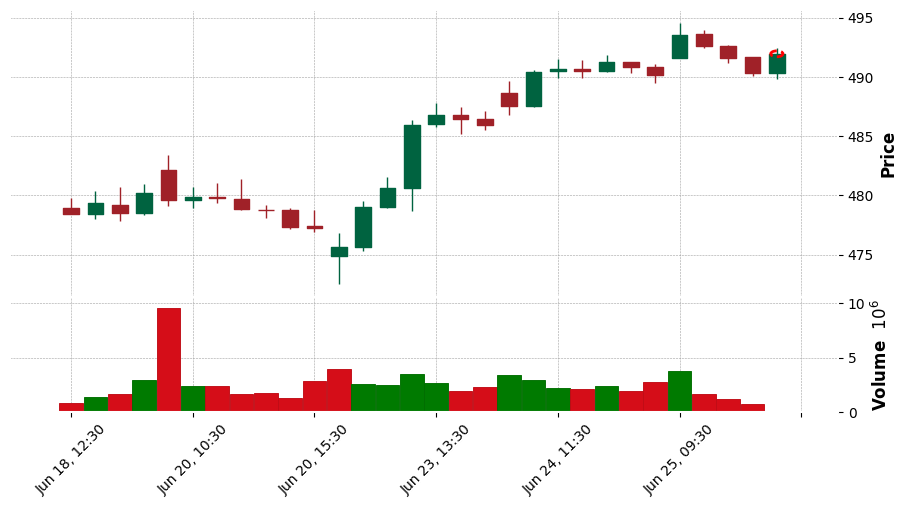

In [ ]:
# from matplotlib.patches import Circle
# from matplotlib.dates import date2num

# # Step 1: Convert timestamp to x-axis value
# x_coord = combined_df.index.get_loc(next_hour)
# y_coord = predicted_close  # or combined_df.loc[next_hour, 'Close']


# # Step 2: Draw the circle
# circle = Circle(
#     (x_coord, y_coord),
#     radius=0.25,
#     edgecolor='red',
#     facecolor='none',
#     linewidth=2,
#     linestyle='--',
#     zorder=10  # this brings it to the front
# )


# # Step 3: Add to the plot
# fig, axlist = mpf.plot(
#     combined_df,
#     type='candle',
#     style='charles',
#     volume=True,
#     returnfig=True,
#     figratio=(12,6)
# )

# price_ax = axlist[0]
# price_ax.add_patch(circle)

# plt.show()


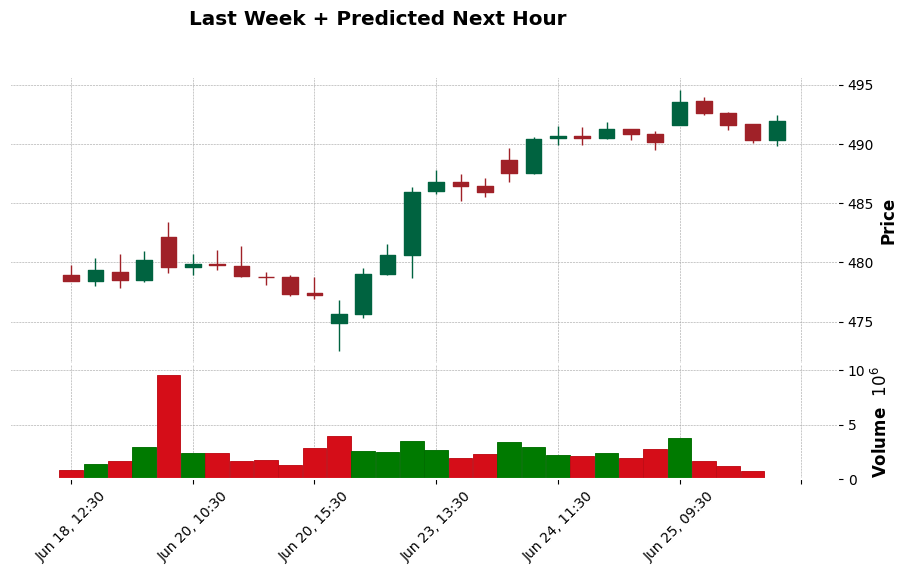

In [ ]:
# highlight = mpf.make_addplot(
#     combined_df['Close'].iloc[-1:],  # Only the predicted candle
#     type='scatter',
#     markersize=120,
#     marker='v',
#     color='gold'
# )


# mpf.plot(
#     combined_df,
#     type='candle',
#     style='charles',
#     volume=True,
#     title='Last Week + Predicted Next Hour',
#     figratio=(12,6)
# )

# # plt.plot(prediction_df.index, prediction_df['Close'], linestyle='dashed', marker='o', color='red')
# # plt.title('Predicted Close Price for Next Hour')
# # plt.show()